In [1]:
#Import some libraries
import numpy as np
import pandas as pd
# from thermoModel import *
from generateThermocline import generateThermocline
from maxDepth import maxDepth
from julianToNormal import jd_to_date
import matplotlib.pyplot as plt
from Net import Net
from global_land_mask import globe
import os
import xarray
import torch
import geopandas as gpd
import geodatasets

In [13]:
# setup global variables
latRange = [45,90]                # range of world latitudes (degrees)
longRange = [-45,180]             # range of world longitudes (degrees)
# dateRange = [2455562.5, 2455927.5]  # range of dates (julian time/days)
dateRange = [2455207, 2455207+380]

areaIncr = 500        # world area grid (degrees)
depthIncr = 1       # depth increment (meter)
dateIncr = 14        # date increment (days)
tempCutoff = 1      # thermocline temperature cutoff (K or degC)

latArray = np.arange(latRange[0], latRange[1], areaIncr)
longArray = np.arange(longRange[0], longRange[1], areaIncr)
dateArray = np.arange(dateRange[0], dateRange[1], dateIncr)

In [14]:
def generateThermoclineActual(df, lat, long, thermoActualPath):
    err = 1
    filtered_df = df.loc[(df['Latitude'].between(lat - err, lat + err)) 
            & (df['Longitude'].between(long - err, long + err)), ['Depth', 'Temperature']]
    # not enough data to filter by time as well
    sorted_df = filtered_df.sort_values(by=['Depth'])
    
    fig, ax = plt.subplots()
    ax.plot(sorted_df["Temperature"], sorted_df["Depth"])  
    ax.set_xlabel('Temperature ($^\circ$C)')
    ax.set_ylabel('Depth (m)')
    ax.set_title(f'Thermocline Actual for Lat: {lat:,.1f} Long: {long:,.1f}')
    ax.invert_yaxis()
    plt.savefig(f'{thermoActualPath}/ThermoclineActual_{lat:,.1f}_{long:,.1f}.png')
    plt.close('all')

    return sorted_df

In [15]:
def generateSurfaceTempActualMap(plotDf, surfaceTempActualPath, date):
    plotColor = "lightgrey"
    opacity = 0.3
    worldmap = gpd.read_file(geodatasets.get_path("naturalearth.land"))

    # Creating axes and plotting world map
    fig, ax = plt.subplots(figsize=(12, 6))
    worldmap.plot(color=plotColor, ax=ax)

    # Plotting our Impact Energy data with a color map
    x = plotDf['Longitude']
    y = plotDf['Latitude']
    z = plotDf['Surface_Temp_Actual']
    plt.scatter(x, y, c=z, alpha=opacity, marker=".")
    plt.colorbar(label='Actual Surface Temp ($^\circ$C)')
    plt.title("Global Actual Surface Temperature Map")
    plt.xlabel("Longitude ($^\circ$)")
    plt.ylabel("Latitude ($^\circ$)")

    year,month,day = jd_to_date(date)
    plt.savefig(f'{surfaceTempActualPath}/SurfaceTempActual_{int(month)}-{int(day)}-{str(int(year))[2:]}.png')
    plt.close('all')


In [2]:
# import training dataset for depth checking
print("Importing training data....")
train_dataset = "practiceData3Years.nc"
ds = xarray.open_dataset(train_dataset)
df = ds.to_dataframe()

# create results directories if it doesn't exist
print("Creating directories....")
resultsPath = "ResultsTest"
thermoPath = resultsPath + "/ThermoclinePlots"
thermoActualPath = resultsPath + "/ThermoclineActualPlots"
surfaceTempActualPath = resultsPath + "/SurfaceTempActualMaps"
if not os.path.exists(resultsPath):
    os.makedirs(resultsPath)
    os.makedirs(thermoPath)
    os.makedirs(thermoActualPath)
    os.makedirs(surfaceTempActualPath)
    print("Directories Created Successfully")

# import ML model
print("Importing model....")
modelPath = "OTEC_miniBatchState.pth"
net = Net()
net.load_state_dict(torch.load(modelPath))
net.eval()

Importing training data....
Creating directories....
Importing model....


Net(
  (fc1): Linear(in_features=4, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=100, bias=True)
  (fc5): Linear(in_features=100, out_features=100, bias=True)
  (fc6): Linear(in_features=100, out_features=1, bias=True)
)

In [17]:
# seasonal thermocline study ** test in actual model
err = 1
latBetween = df['Latitude'].between(45 - err, 45 + err)
longBetween = df['Longitude'].between(-45 - err, -45 + err)
filtered_df = df.loc[latBetween & longBetween]

sorted_df = filtered_df.sort_values(by=['Julian_Time'])
# sorted_df['Julian_Time'].unique()

coldDf = sorted_df.loc[sorted_df['Julian_Time'].between(2455207, 2455207+7)] # plot #1
year,month,day=jd_to_date(2455207)
fig, ax = plt.subplots()
ax.plot(coldDf['Temperature'], coldDf["Depth"], marker = '.', linestyle = 'None')  
ax.set_xlabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)')
ax.set_title(f'Thermocline for Lat: {45:,.1f} Long: {-45:,.1f} Date: {int(month)}-{int(day)}-{str(int(year))[2:]}')
ax.invert_yaxis()
plt.savefig(f'Thermocline_{45:,.1f}_{-45:,.1f}_{int(month)}-{int(day)}-{str(int(year))[2:]}.png')
plt.close('all')

hotDf = sorted_df.loc[sorted_df['Julian_Time'].between(2455419, 2455419 + 7)] # plot #1
year,month,day=jd_to_date(2455419)
fig, ax = plt.subplots()
ax.plot(hotDf['Temperature'], hotDf["Depth"], marker = '.', linestyle = 'None')  
ax.set_xlabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)')
ax.set_title(f'Thermocline for Lat: {45:,.1f} Long: {-45:,.1f} Date: {int(month)}-{int(day)}-{str(int(year))[2:]}')
ax.invert_yaxis()
plt.savefig(f'Thermocline_{45:,.1f}_{-45:,.1f}_{int(month)}-{int(day)}-{str(int(year))[2:]}.png')
plt.close('all')
# sorted_df.loc[sorted_df['Julian_Time'].between(2455562.5+14 - 1, 2455562.5+14 + 1)]
# sorted_df.loc[sorted_df['Julian_Time'].between(2455562.5+14 - 1, 2455562.5+14 + 1)]
# sorted_df.max()['Julian_Time']
# sorted_df.min()['Julian_Time']
# sorted_df['Julian_Time'].between(2455207.41+14*15 - 14, 2455207.41+14*15 + 14)

In [18]:
# has to be defined here doesn't work if imported for some reason
def minDepthTemperature(df, lat, long, areaIncr):    
    i = 0.5
    err = areaIncr*i
    latBetween = df['Latitude'].between(lat - err, lat + err)
    longBetween = df['Longitude'].between(long - err, long + err)
    filtered_df = df.loc[latBetween & longBetween,['Depth', 'Temperature']]
    if filtered_df.empty:
        return -1
    sorted_df = filtered_df.sort_values(by=['Depth'])
    print(len(sorted_df))

    return float(sorted_df['Temperature'].iloc[0])


In [19]:
# TODO CHECK IF SURFACE TEMP MAP GENERATION WORKS AND IF VALUES ARE RIGHT ** START HERE -> RUN THIS 

# main for loop to generate thermocline and get exergy for each time
print("Entering main loop....") 
for date in dateArray:
    # generate new dataframe for storing plotting variables worldwide for each new date
    print(f"Initializing plots dataframe for {date:.1f}....")
    plotDf = pd.DataFrame(columns = ['Latitude', 'Longitude', 'Surface_Temp_Actual'])
    
    # generate data for each location 
    print(f"Generating data for {date:.1f}....")
    for lat in latArray:
        for long in longArray:
            
            # land mask
            if not globe.is_land(lat, long):
                # get maximum depth of location from database
                maxDep = maxDepth(df, lat, long, areaIncr) 

                # generate thermocline for location using ML model
                print(f"Generating thermoclines for {lat:.1f}_{long:.1f}_{date:.1f}....") 
                tempDf = generateThermocline(lat, long, date, maxDep, depthIncr, net, thermoPath, True)
                tempDfActual = generateThermoclineActual(df, lat, long, thermoActualPath)

                # add data to plotting dataframe
                # print(lat, long)
                # plotDf = plotDf._append({'Latitude' : lat, 
                #                         'Longitude' : long, 
                #                         'Surface_Temp_Actual': minDepthTemperature(df, lat, long, areaIncr)}, ignore_index = True)
    
    # generateSurfaceTempActualMap(plotDf, surfaceTempActualPath, date)

Entering main loop....
Initializing plots dataframe for 2455207.0....
Generating data for 2455207.0....
Generating thermoclines for 45.0_-45.0_2455207.0....
Initializing plots dataframe for 2455221.0....
Generating data for 2455221.0....
Generating thermoclines for 45.0_-45.0_2455221.0....
Initializing plots dataframe for 2455235.0....
Generating data for 2455235.0....
Generating thermoclines for 45.0_-45.0_2455235.0....
Initializing plots dataframe for 2455249.0....
Generating data for 2455249.0....
Generating thermoclines for 45.0_-45.0_2455249.0....
Initializing plots dataframe for 2455263.0....
Generating data for 2455263.0....
Generating thermoclines for 45.0_-45.0_2455263.0....
Initializing plots dataframe for 2455277.0....
Generating data for 2455277.0....
Generating thermoclines for 45.0_-45.0_2455277.0....
Initializing plots dataframe for 2455291.0....
Generating data for 2455291.0....
Generating thermoclines for 45.0_-45.0_2455291.0....
Initializing plots dataframe for 245530

In [ ]:
# CONTOUR MAP TESTING BELOW

In [38]:
# Implementation of matplotlib function
import numpy as np
import matplotlib.pyplot as plt
from numpy import ma
from matplotlib import ticker, cm

N = 1000
x = np.linspace(-6.0, 6.0, N)
y = np.linspace(-7.0, 7.0, N)
X, Y = np.meshgrid(x, y)

Z1 = np.exp(-(X)**2 - (Y)**2)
z = 50 * Z1
z[:5, :5] = -1
z = ma.masked_where(z <= 0, z)

worldmap = gpd.read_file(geodatasets.get_path("naturalearth.land"))

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color='lightgrey', ax=ax)

# fig, ax = plt.subplots()
cs = ax.contourf(X, Y, z, locator = ticker.LogLocator(),
				cmap ="Greens")

cbar = fig.colorbar(cs)
ax.set_title('matplotlib.axes.Axes.contourf() Example')

plt.show()

In [43]:
#Import some libraries
import numpy as np
import pandas as pd
# from thermoModel import *
from generateThermocline import generateThermocline
from maxDepth import maxDepth
from julianToNormal import jd_to_date
import matplotlib.pyplot as plt
from Net import Net
from global_land_mask import globe
import os
import xarray
import torch
import geopandas as gpd
import geodatasets

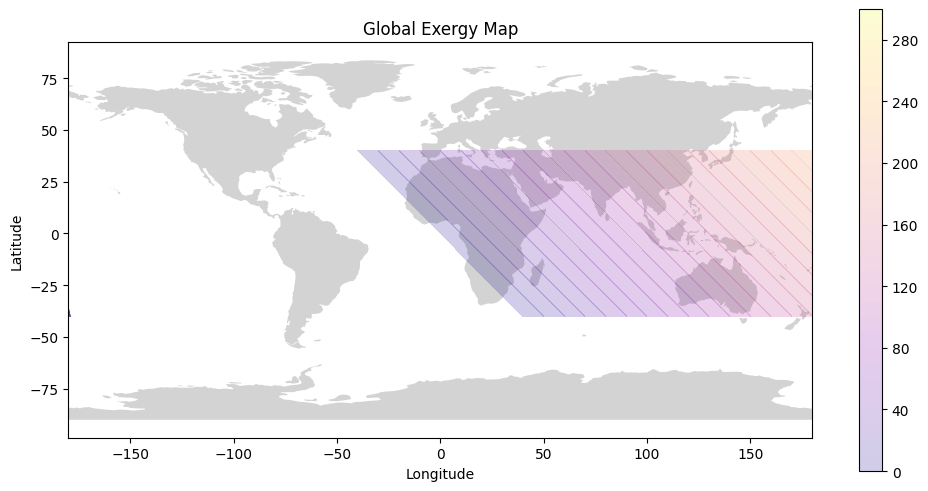

In [122]:
# PLOTTING STRUCTURE IS COMPLETE (ALSO WITH ADDITIONAL FEATURES) JUST NEED TO PLOT FROM DATA
# TODO: 1. Convert 1d exergy data to 2d grid/coordinate form to plot on world map (use for loops maybe)
#       2. run 1 degree scatter plots on gilbreth (update local branch with cluster changes and push first) **
# Issues: 1. data can't be shaped into rectangle or square since not every y has an x, vice versa, investigate
#         2. contour plots can't unblend data that is on land? maybe use levels to get rid of land data?
#            -> so maybe it's better to use scatter after all since it doesn't plot on land
#            -> or manually create lat and long array using areaincr and change the exergy on land to 0 and constraint
#               contour map to only display exergy >0
areaIncr = 5
plotDf = pd.read_csv("Extras/Results5/ResultsCSV/Results_1-1-11.csv")
worldmap = gpd.read_file(geodatasets.get_path("naturalearth.land"))

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color='lightgrey', ax=ax)

colMap = plt.cm.plasma
colMap.set_bad(color="k", alpha=1.0)
colMap.set_under(color="lightgrey", alpha=1.0)

# L_lw = np.linspace(0, 300, 31) # optional to set colorbar bounds

lon = np.linspace(-180, 180, int(360*(1/areaIncr)+1))
lat = np.linspace(-90, 90, int(180*(1/areaIncr)+1))
# lon = plotDf["Longitude"].unique()
# lat = plotDf["Latitude"].unique()
longitude, latitude = np.meshgrid(lon, lat) 
# optional to convert 1d arrays to grid form, lon/lat (1D) or longitude/latitude (grid) will work

# testing
z = longitude + latitude 
z[0][0] = 220 # testing

# cs = ax.contourf(lon, lat, z, L_lw, cmap=colMap, alpha=0.2)
cs = ax.contourf(lon, lat, z, cmap=colMap, alpha=0.2)
# cbar = fig.colorbar(cs, ax=ax, fraction=0.0178, pad=0.02)
cbar = fig.colorbar(cs)
ax.set_title("Global Exergy Map")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()
# fig.savefig(filename)

In [16]:
lon = np.linspace(-180, 180, int(360*(1/5)+1))
lon


array([-180., -175., -170., -165., -160., -155., -150., -145., -140.,
       -135., -130., -125., -120., -115., -110., -105., -100.,  -95.,
        -90.,  -85.,  -80.,  -75.,  -70.,  -65.,  -60.,  -55.,  -50.,
        -45.,  -40.,  -35.,  -30.,  -25.,  -20.,  -15.,  -10.,   -5.,
          0.,    5.,   10.,   15.,   20.,   25.,   30.,   35.,   40.,
         45.,   50.,   55.,   60.,   65.,   70.,   75.,   80.,   85.,
         90.,   95.,  100.,  105.,  110.,  115.,  120.,  125.,  130.,
        135.,  140.,  145.,  150.,  155.,  160.,  165.,  170.,  175.,
        180.])

In [45]:
def maxDepthTest(df, lat, long, areaIncr):
    i = 0
    err = areaIncr*i
    latBetween = df['Latitude'].between(lat - err, lat + err)
    longBetween = df['Longitude'].between(long - err, long + err)
    filtered_df = df.loc[latBetween & longBetween, ['Depth']]
    # print(filtered_df)
    while filtered_df.empty:
        i += 0.25
        # print(i)
        err = areaIncr*i
        latBetween = df['Latitude'].between(lat - err, lat + err)
        longBetween = df['Longitude'].between(long - err, long + err)
        filtered_df = df.loc[latBetween & longBetween,['Depth']]
        # print(filtered_df)
        
    return int(filtered_df.max()['Depth'])

In [4]:
# from generateThermocline import generateThermocline
# maxDepth(df,-52,40,1)

generateThermocline(-52,40,2455562.5,maxDepth(df,-52,40,1),1,net,"Results/ThermoclinePlots", False)
# maxDepthTest(df,-52,40,1)

False
how many GPUs? =  0
{'Latitude': [-52], 'Longitude': [40], 'Julian_Time': [2455562.5], 'Depth': [0]}


,Depth,Temperature
0,0,3.157983


In [40]:
# z[0][0] = 220
# z
df.loc[25487635, 'Latitude']
# df.loc[25487636, 'Longitude']

30.219

In [116]:
lon = plotDf["Longitude"].unique()
lat = plotDf["Latitude"].unique()
np.reshape(plotDf["Exergy"], (lat.size, lon.size))

ValueError: cannot reshape array of size 101 into shape (8,18)